In [ ]:
from skimage import feature
from imutils import paths
import numpy as np
import argparse
import cv2 as cv
import os
import pandas as pd
from google.colab.patches import cv2_imshow


#Pre-processing function


In [ ]:
def preprocess(image, image_size=128):
		image = cv.cvtColor(image, cv.COLOR_BGR2GRAY) 
		image = cv.resize(image, (image_size, image_size))
		image = cv.threshold(image, 0, 255, cv.THRESH_BINARY_INV | cv.THRESH_OTSU)[1] 
		return image

#HOG (Histogram of Oriented Gradient) Function

In [ ]:
def quantify_image_hog(image) : 
  features = feature.hog(image, orientations=9, pixels_per_cell=(10, 10), cells_per_block=(2, 2), transform_sqrt=True, block_norm="L1")
  return features

#LBP (Local Binary Pattern) Function

In [ ]:
def quantify_image_lbp(image) : 
  features = feature.local_binary_pattern(image, 24, 8, method='uniform')

  (hist, _) = np.histogram(features.flatten(), bins=np.arange(0, 27), range=(0, 26))
  hist = hist.astype("float")
  hist /= (hist.sum()+ 1e-7)

  return hist

#Melakukan pengetesan, apakah fungsi diatas berjalan dengan baik ?

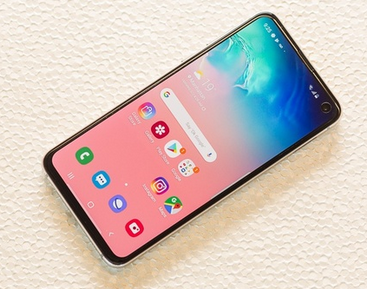

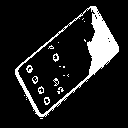

HOG Test
[0. 0. 0. ... 0. 0. 0.] 4356
LBP Test
[9.88769531e-03 7.62939453e-03 1.64794922e-03 6.10351562e-04
 6.10351562e-04 4.27246094e-04 6.10351562e-05 0.00000000e+00
 3.05175781e-04 1.09863281e-03 1.15966797e-03 2.38037109e-03
 2.92968750e-03 4.57763672e-03 3.66210937e-03 4.69970703e-03
 2.80761719e-03 3.54003906e-03 2.74658203e-03 2.80761719e-03
 1.28173828e-03 1.83105469e-03 4.88281250e-04 3.17382812e-03
 8.89038086e-01 5.05981445e-02] 26


In [ ]:
image_test = cv.imread('drive/My Drive/Colab_Test/Dataset/Computer Vision/phones/phones.png')

test_preprocessed = preprocess(image_test, image_size = 128)

cv2_imshow(image_test)
cv2_imshow(test_preprocessed)

features_hog = quantify_image_hog(test_preprocessed)
features_lbp = quantify_image_lbp(test_preprocessed)

print("HOG Test")
print(features_hog, len(features_hog))
print("LBP Test")
print(features_lbp, len(features_lbp))

#Data Split Function (Untuk split train dan test)

In [ ]:
def load_split(path, image_size = 128, extraction_method = 'hog') : 
  image_paths = list(paths.list_images(path))
  data = []
  labels = []

  for image_path in image_paths :
    label = image_path.split(os.path.sep)[-2]

    image = cv.imread(image_path)
    image = preprocess(image, image_size = image_size)

    if extraction_method == 'hog':
      features = quantify_image_hog(image)
    elif extraction_method == 'lbp' :
      features = quantify_image_lbp(image)

    data.append(features)
    labels.append(label)

  return (np.array(data), np.array(labels))

In [ ]:
dataset_dir = '/content/drive/My Drive/Colab_Test/Dataset/Computer Vision/wave'

trainingPath = os.path.join(dataset_dir, "training")
testingPath = os.path.join(dataset_dir, "testing")

#**HOG Size = 128**

In [ ]:
resize_image_size = 128
extraction_method = 'hog'

In [ ]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

#Machine Learning

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
label_train = le.fit_transform(label_train)
label_test = le.transform(label_test)

In [ ]:
print("List Label Train :")
print(label_train)
print("\n List Label Test : ")
print(label_test)

List Label Train :
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

 List Label Test : 
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

#LinearSVC

In [ ]:
lsvc = LinearSVC()
lsvc.fit(feature_train, label_train)
predictions = lsvc.predict(feature_test)

print("Akurasi Linear SVC         ->",round(lsvc.score(feature_test, label_test),3))
print("F1 Score Linear SVC        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Linear SVC ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Linear SVC    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Linear SVC         -> 0.667
F1 Score Linear SVC        -> 0.6666666666666666
Precision Score Linear SVC -> 0.6666666666666666
Recall Score Linear SVC    -> 0.6666666666666666


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67        15
           1       0.67      0.67      0.67        15

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



#Logistic Regression


In [ ]:
log_reg = LogisticRegression()
log_reg.fit(feature_train, label_train)
predictions = log_reg.predict(feature_test)

print("Akurasi Logistic Regression         ->",round(log_reg.score(feature_test, label_test),3))
print("F1 Score Logistic Regression        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Logistic Regression ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Logistic Regression    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Logistic Regression         -> 0.667
F1 Score Logistic Regression        -> 0.6651785714285714
Precision Score Logistic Regression -> 0.6696832579185521
Recall Score Logistic Regression    -> 0.6666666666666666


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.60      0.64        15
           1       0.65      0.73      0.69        15

    accuracy                           0.67        30
   macro avg       0.67      0.67      0.67        30
weighted avg       0.67      0.67      0.67        30



#Random Forest Classifier

In [ ]:
rand_clas = RandomForestClassifier(n_estimators = 27, random_state=10)
rand_clas.fit(feature_train, label_train)
predictions = rand_clas.predict(feature_test)

print("Akurasi Random Forest Classifier         ->",round(rand_clas.score(feature_test, label_test),3))
print("F1 Score Random Forest Classifier        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Random Forest Classifier ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Random Forest Classifier    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Random Forest Classifier         -> 0.7
F1 Score Random Forest Classifier        -> 0.6996662958843158
Precision Score Random Forest Classifier -> 0.7008928571428572
Recall Score Random Forest Classifier    -> 0.7


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

           0       0.69      0.73      0.71        15
           1       0.71      0.67      0.69        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



In [ ]:
testing_paths = list(paths.list_images(testingPath))
images = []

for testing_path in testing_paths[:25]:
	image = cv.imread(testing_path)
	output = image.copy()
	output = cv.resize(output, (128, 128))

	image = preprocess(image, image_size=resize_image_size)

	if extraction_method == 'hog':
		features = quantify_image_hog(image)
	elif extraction_method == 'lbp':
		features = quantify_image_lbp(image)
   
	preds = lsvc.predict([features])
	label = le.inverse_transform(preds)[0]

	color = (0, 255, 0) if label == "healthy" else (0, 0, 255)
	cv.putText(output, label, (3, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
	images.append(output)

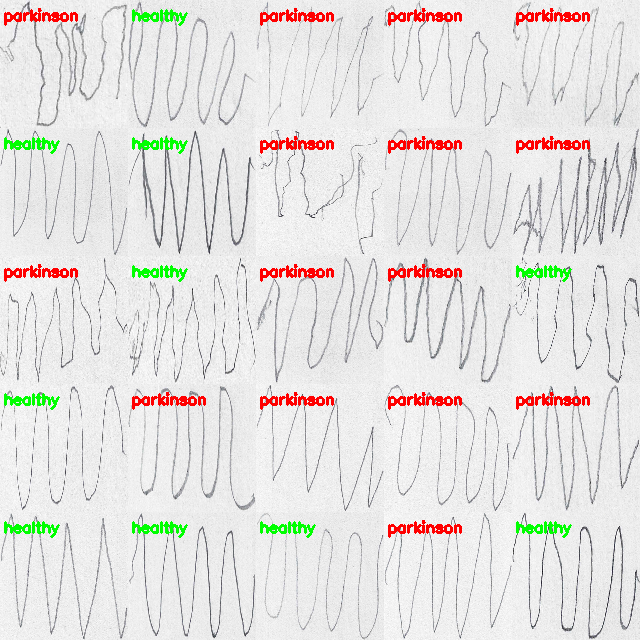

In [ ]:
 
from imutils import build_montages

montage = build_montages(images, (128, 128), (5, 5))[0]

cv2_imshow(montage)

#**LBP Size = 128**

In [ ]:
resize_image_size = 128
extraction_method = 'lbp'

In [ ]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

#LinearSVC

In [ ]:
lsvc = LinearSVC()
lsvc.fit(feature_train, label_train)
predictions = lsvc.predict(feature_test)

print("Akurasi Linear SVC         ->",round(lsvc.score(feature_test, label_test),3))
print("F1 Score Linear SVC        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Linear SVC ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Linear SVC    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Linear SVC         -> 0.567
F1 Score Linear SVC        -> 0.5622895622895623
Precision Score Linear SVC -> 0.5694444444444444
Recall Score Linear SVC    -> 0.5666666666666667


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.56      0.67      0.61        15
   parkinson       0.58      0.47      0.52        15

    accuracy                           0.57        30
   macro avg       0.57      0.57      0.56        30
weighted avg       0.57      0.57      0.56        30



#Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(feature_train, label_train)
predictions = log_reg.predict(feature_test)

print("Akurasi Logistic Regression         ->",round(log_reg.score(feature_test, label_test),3))
print("F1 Score Logistic Regression        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Logistic Regression ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Logistic Regression    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Logistic Regression         -> 0.5
F1 Score Logistic Regression        -> 0.4994438264738599
Precision Score Logistic Regression -> 0.5
Recall Score Logistic Regression    -> 0.5


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.50      0.53      0.52        15
   parkinson       0.50      0.47      0.48        15

    accuracy                           0.50        30
   macro avg       0.50      0.50      0.50        30
weighted avg       0.50      0.50      0.50        30



#Random Forest Classifier

In [ ]:
rand_clas = RandomForestClassifier(n_estimators = 27, random_state=10)
rand_clas.fit(feature_train, label_train)
predictions = rand_clas.predict(feature_test)

print("Akurasi Random Forest Classifier         ->",round(rand_clas.score(feature_test, label_test),3))
print("F1 Score Random Forest Classifier        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Random Forest Classifier ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Random Forest Classifier    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Random Forest Classifier         -> 0.533
F1 Score Random Forest Classifier        -> 0.5333333333333333
Precision Score Random Forest Classifier -> 0.5333333333333333
Recall Score Random Forest Classifier    -> 0.5333333333333333


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.53      0.53      0.53        15
   parkinson       0.53      0.53      0.53        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



#**HOG Size = 300**

In [ ]:
resize_image_size = 300
extraction_method = 'hog'

In [ ]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

#Linear SVC

In [ ]:
lsvc = LinearSVC()
lsvc.fit(feature_train, label_train)
predictions = lsvc.predict(feature_test)

print("Akurasi Linear SVC         ->",round(lsvc.score(feature_test, label_test),3))
print("F1 Score Linear SVC        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Linear SVC ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Linear SVC    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Linear SVC         -> 0.733
F1 Score Linear SVC        -> 0.7321428571428572
Precision Score Linear SVC -> 0.7375565610859729
Recall Score Linear SVC    -> 0.7333333333333334


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.71      0.80      0.75        15
   parkinson       0.77      0.67      0.71        15

    accuracy                           0.73        30
   macro avg       0.74      0.73      0.73        30
weighted avg       0.74      0.73      0.73        30



#Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(feature_train, label_train)
predictions = log_reg.predict(feature_test)

print("Akurasi Logistic Regression         ->",round(log_reg.score(feature_test, label_test),3))
print("F1 Score Logistic Regression        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Logistic Regression ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Logistic Regression    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Logistic Regression         -> 0.7
F1 Score Logistic Regression        -> 0.6996662958843158
Precision Score Logistic Regression -> 0.7008928571428572
Recall Score Logistic Regression    -> 0.7


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.69      0.73      0.71        15
   parkinson       0.71      0.67      0.69        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



#Random Forest Classifier

In [ ]:
rand_clas = RandomForestClassifier(n_estimators = 27, random_state=10)
rand_clas.fit(feature_train, label_train)
predictions = rand_clas.predict(feature_test)

print("Akurasi Random Forest Classifier         ->",round(rand_clas.score(feature_test, label_test),3))
print("F1 Score Random Forest Classifier        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Random Forest Classifier ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Random Forest Classifier    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Random Forest Classifier         -> 0.6
F1 Score Random Forest Classifier        -> 0.5927601809954751
Precision Score Random Forest Classifier -> 0.6076555023923444
Recall Score Random Forest Classifier    -> 0.6


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.64      0.47      0.54        15
   parkinson       0.58      0.73      0.65        15

    accuracy                           0.60        30
   macro avg       0.61      0.60      0.59        30
weighted avg       0.61      0.60      0.59        30



#**LBP Size 300**

In [ ]:
resize_image_size = 300
extraction_method = 'lbp'

In [ ]:
(feature_train, label_train) = load_split(trainingPath, image_size=resize_image_size, extraction_method=extraction_method)
(feature_test, label_test) = load_split(testingPath, image_size=resize_image_size, extraction_method=extraction_method)

#Linear SVC

In [ ]:
lsvc = LinearSVC()
lsvc.fit(feature_train, label_train)
predictions = lsvc.predict(feature_test)

print("Akurasi Linear SVC         ->",round(lsvc.score(feature_test, label_test),3))
print("F1 Score Linear SVC        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Linear SVC ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Linear SVC    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Linear SVC         -> 0.533
F1 Score Linear SVC        -> 0.5333333333333333
Precision Score Linear SVC -> 0.5333333333333333
Recall Score Linear SVC    -> 0.5333333333333333


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.53      0.53      0.53        15
   parkinson       0.53      0.53      0.53        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



#Logistic Regression

In [ ]:
log_reg = LogisticRegression()
log_reg.fit(feature_train, label_train)
predictions = log_reg.predict(feature_test)

print("Akurasi Logistic Regression         ->",round(log_reg.score(feature_test, label_test),3))
print("F1 Score Logistic Regression        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Logistic Regression ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Logistic Regression    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Logistic Regression         -> 0.533
F1 Score Logistic Regression        -> 0.5333333333333333
Precision Score Logistic Regression -> 0.5333333333333333
Recall Score Logistic Regression    -> 0.5333333333333333


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.53      0.53      0.53        15
   parkinson       0.53      0.53      0.53        15

    accuracy                           0.53        30
   macro avg       0.53      0.53      0.53        30
weighted avg       0.53      0.53      0.53        30



#Random Forest Classifier

In [ ]:
rand_clas = RandomForestClassifier(n_estimators = 27, random_state=10)
rand_clas.fit(feature_train, label_train)
predictions = rand_clas.predict(feature_test)

print("Akurasi Random Forest Classifier         ->",round(rand_clas.score(feature_test, label_test),3))
print("F1 Score Random Forest Classifier        ->", f1_score(label_test, predictions, average="macro"))
print("Precision Score Random Forest Classifier ->", precision_score(label_test, predictions, average="macro"))
print("Recall Score Random Forest Classifier    ->", recall_score(label_test, predictions, average="macro"))

Akurasi Random Forest Classifier         -> 0.7
F1 Score Random Forest Classifier        -> 0.6996662958843158
Precision Score Random Forest Classifier -> 0.7008928571428572
Recall Score Random Forest Classifier    -> 0.7


In [ ]:
print(classification_report(label_test, predictions))

              precision    recall  f1-score   support

     healthy       0.71      0.67      0.69        15
   parkinson       0.69      0.73      0.71        15

    accuracy                           0.70        30
   macro avg       0.70      0.70      0.70        30
weighted avg       0.70      0.70      0.70        30



#Dari pengujian diatas, didapatkan akurasi paling tinggi dengan metode extraction HOG dengan image size adalah 300 serta dengan menggunakan algoritma Linear SVC, dengan akurasi 0.733 dan F1 Score 0.732.

#Dengan begitu dapat disimpulkan ada kemungkinan semakinn besar image_size semakin besar juga hasil yang didapatkan.